# QOSF - Task 2 

## Dependencies

Qiskit 
  > !pip install qiskit

<ins>Question</ins> 

Implement a circuit that returns $|01\rangle$ and $|10\rangle$ with equal probability.

<ins>Requirements</ins> 
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

<ins>Bonus question:</ins>  

How to make sure you produce state $|01\rangle$ + $|10\rangle$ and not $|01\rangle$ - $|10\rangle$?

In [1]:
#Importing the nesessary libary. For this task I would be making use of Qiskit
from qiskit import execute, QuantumCircuit, Aer 
#For noise
import qiskit.providers.aer.noise as noise
import numpy as np
import random
import matplotlib.pyplot as plt

## Implementation of the Quantum Circuit 

From the use of the Controlled-NOT (CNOT) gate, X gate, and Hadamard gate, we can implement the quantum circuit that $|01\rangle$ and $|10\rangle$ with equal probability. 

<ins>Circuit</ins>

1) We use $|00\rangle$, as our starting state.

2) We apply X gate to Qubit 2 and H gate to Qubit 1.

3) Then we apply the CNOT gate with target as Qubit 2 with control input as Qubit 1.

We get the following equal probability of 0.5 ideally when we measure $\frac{|01\rangle + |10\rangle}{\sqrt{2}}$

***The following gates can be implemented using Rx, Ry, and Cx gates.***

In [2]:
#The Quantum Circuit Model 
circuit = QuantumCircuit(2)

In [3]:
# Appling the H gate of Qubit 0
circuit.ry(np.pi/2,0)
circuit.rx(np.pi/2,0)

In [4]:
# Appling the H gate of Qubit 1
circuit.ry(np.pi,1)

In [5]:
# Applying CNOT gate with 
# qubit 0 - control qubit 
# qubit 1 - targer qubit
circuit.cx(0,1)

In [6]:
#Visualizing the circuit
circuit.draw()

┌──────────┐┌──────────┐     
q_0: ┤ RY(pi/2) ├┤ RX(pi/2) ├──■──
     └┬────────┬┘└──────────┘┌─┴─┐
q_1: ─┤ RY(pi) ├─────────────┤ X ├
      └────────┘             └───┘

In [7]:
#Executing the circuit without noice
simulator = Aer.get_backend('qasm_simulator')
backend = Aer.get_backend('statevector_simulator')
test_result = execute(circuit, backend, shots=1000).result()
probabilities = test_result.get_counts() 

print("probability of 00 - " + str(probabilities["01"]) + "\n" "probability of 01 - " + str(probabilities['10']) + "\n")

probability of 00 - 0.5
probability of 01 - 0.5



## Hyperparamters for the gradient descent algorithm (with momentum)

Learning rate
> lr = 0.1

Momentum Coefficent
> momentum_c = 0.65

Number of Iterations
> iterations = 1000

In [8]:
#Hyperparameters
lr = 0.1
momentum_c = 0.65
iterations = 1000
measurement_count = [1000, 100, 10 , 1]

x_probability = {"1000": [], "100": [], "10": [], "1": []}
equal_probability = {"1000": [], "100": [], "10": [], "1": []}
h_probability = {"1000": [], "100": [], "10": [], "1": []}

In [9]:
#Returns the measurements
def measurement(circuit, measurements):    
    circuit.measure_all()
    result = execute(circuit, simulator, shots = measurements, noise_model=noise.NoiseModel()).result()
    return(result.get_counts(circuit))

#Returns the state
def statevector(circuit):
    return(execute(circuit, backend).result().get_statevector())    

In [10]:
#Return the probalility of all the states of N - Qubit
def probability_function(no_of_qubit, measurements, measurement_count):
    result = np.zeros(no_of_qubit)
    for i in measurements.keys():
        result[int(i,2)] = int(measurements[i]) / measurement_count
    return(result)

<ins>Objective function for X Gate</ins>

( Probability($|0\rangle$) - $0 )^2$ + ( Probability($|1\rangle$) - $1 )^2$


<ins>Objective function for returning $|10\rangle$  and  $|01\rangle$  with equal probability</ins>

( Probability($|0\rangle$) - $\frac{1}{2} )^2$ + ( Probability($|1\rangle$) - $\frac{1}{2} )^2$


<ins>For the bonus question, the following is the objective function</ins>

The state-vector of the parametric circuit in state $|0\rangle$  is compared to the Hadamard gate application in state $|0\rangle$ .

( Statevector$[0]$.real - $\frac{1}{\sqrt{2}} )^2$ + ( Statevector$[1]$.real - $\frac{1}{\sqrt{2}} )^2$ 

In [11]:
#Objective function for X-Gate 
def objective_function_X(parameters, measurement_count):
    circuit = QuantumCircuit(1) 
    # X gate on qubit 1    
    circuit.ry(parameters[0], 0)    
    count = measurement(circuit, measurement_count)
    probability = probability_function(2, count, measurement_count) 
    cost = ((float(probability[0]) - 0)**2 + (float(probability[1]) - 1)**2)
    return cost

#Objective function for returning |10⟩  and  |01⟩  with equal probability     
def equal_objective_function(parameters, measurement_count):
    circuit = QuantumCircuit(1)    
    circuit.ry(parameters[0],0)
    circuit.rx(parameters[1],0)
    count = measurement(circuit, measurement_count)
    probability = probability_function(4, count, measurement_count)    
    cost = ((float(probability[0]) - 0.5)**2 + (float(probability[1]) - 0.5)**2)
    return cost    

#Objective function for returning 0.7070 x (|10⟩  +  |01⟩) with equal probability, and avoiding other combinations.
def objective_function_h(parameters, measurement_count):
    circuit = QuantumCircuit(1)    
    circuit.ry(parameters[0],0)
    circuit.rx(parameters[1],0)
    state_vector = statevector(circuit)
    objective_value = ((float(state_vector[0].real) - (1/2)**(1/2))**2 + (float(state_vector[1].real) - (1/2)**(1/2))**2)
    return objective_value

## Gradient Descent with momentum implementation with the specified hyper parameters

In [12]:
#Initializes the parameters randomly for the parameter vector 
def parameter_initialization(circuit_gates):    
    params = np.random.uniform(low = 0, high = 2 * np.pi , size=(circuit_gates,))
    return params

#The parameter update rule for the gradient descent algorithm 
def update_parameters(parameters, gradient_value, momentum):    
    parameters =  parameters - lr * (gradient_value * momentum_c + (1 - momentum_c) * momentum)
    parameters =  parameters % (2*np.pi) 
    return(parameters)    

#Calculates the derivative of the cost function using the first principle 
def gradient_step(iteration, cost_function, parameters, measurement_count, momentum):   
    upper_limit = cost_function(parameters + 0.005, measurement_count)
    lower_limit = cost_function(parameters, measurement_count)    
    gradient_value = (upper_limit - lower_limit) / 0.005 
    
    if (iteration == 0):
        momentum = gradient_value
        
    parameters = update_parameters(parameters, gradient_value, momentum)
    momentum = gradient_value
    return(parameters, momentum)                         

#Performs gradient descent
def gradient_descent(initial_parameter, cost_function, measurement_count):
    momentum = 0
    global_min_cost = cost_function(initial_parameter, measurement_count)
    global_min_parameter = initial_parameter
    
    for i in range(iterations):
        updated_parameter, momentum = gradient_step(i, cost_function, initial_parameter, measurement_count,  momentum)
        initial_parameter = updated_parameter
        reference_cost = cost_function(initial_parameter, measurement_count)        
        
        if (reference_cost == 0):
            global_min_cost = reference_cost
            global_min_parameter = initial_parameter           
        
        elif (reference_cost < global_min_cost):
            global_min_cost = reference_cost
            global_min_parameter = initial_parameter    

    print("Minimized cost value = " + str(global_min_cost))
    print("Minimized parameter = " + str(global_min_parameter))
    print("\n")
    
    return (global_min_cost , global_min_parameter)

In [13]:
circuit_gates = 1
initial_parameter = parameter_initialization(circuit_gates)
print("Initial parameter = ", initial_parameter)

for i in range(4):
    print("\nMeasurements = ", measurement_count[i])    
    x_probability[str(measurement_count[i])] = gradient_descent(initial_params, objective_function_X, measurement_count[i])    

Initial parameter =  [0.77943382]

Measurements:  1000
Minimized cost value = 0.0
Minimized parameter = [3.08312382]



Measurements:  100
Minimized cost value = 0.0
Minimized parameter = [3.11401913]



Measurements:  10
Minimized cost value = 0.0
Minimized parameter = [3.16032198]



Measurements:  1
Minimized cost value = 0.0
Minimized parameter = [3.08032198]




In [14]:
circuit_gates = 2
initial_parameter = parameter_initialization(circuit_gates)
print("Initial parameter = ", initial_parameter)

for i in range(4):
    print("\nMeasurements = ", measurement_count[i])    
    equal_probability[str(measurement_count[i])]  = gradient_descent(initial_parameter, equal_objective_function, measurement_count[i])

Initial param:  [6.24351446 4.83990833]

Measurements:  1000
Minimized cost value = 0.0
Minimized parameter = [1.59220446 0.18859833]



Measurements:  100
Minimized cost value = 0.0
Minimized parameter = [2.94991446 1.54630833]



Measurements:  10
Minimized cost value = 0.0
Minimized parameter = [4.06669977 2.66309363]



Measurements:  1
Minimized cost value = 0.5
Minimized parameter = [6.24351446 4.83990833]




In [15]:
def parametric_quantum_circuit(mode, parameter_x , parameter_e, measurement_count):
    circuit = QuantumCircuit(2) 
    circuit.ry(parameter_x[0], 1)
    circuit.ry(parameter_e[0],0)
    circuit.rx(parameter_e[1],0)
    circuit.cx(0,1)    
    state_vector = statevector(circuit)
    samples = measurement(circuit, measurement_count)   
    
    #Mode = 1 is for bonus question
    if (mode == 1):
        return(state_vector)    
    
    else:
        return(samples)
    
def results(x_probability, equal_probability):
   
    samples = []
    objective_value = []
    
    for i in range(4):    
        
        samples.append(parametric_quantum_circuit(0,x_probability[str(measurement_count[i])][1], 
                                                  equal_probability[str(measurement_count[i])][1], 
                                                  measurement_count[i])) 
        
        probability = probability_function(4, samples[i], measurement_count[i])
        objective_value.append(((float(probability[0]) - 0)**2 + (float(probability[1]) - 0.5)**2 + (float(probability[2]) - 0.5)**2 + (float(probability[3]) - 0)**2))
      
               
    return samples, objective_value

In [16]:
samples, objective_value = results(x_probability, equal_probability)

# Results

We can infer from the results that as the number of measurements increases, the loss decreases i.e, the error decreases. 

Text(0, 0.5, 'Loss Function')

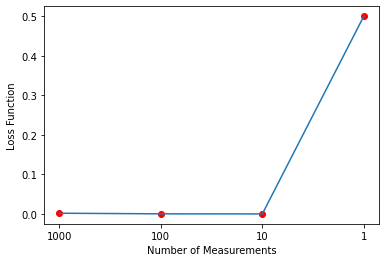

In [17]:
plt.plot(['1000', '100', '10', '1'], objective_value, 'ro')
plt.plot(['1000', '100', '10', '1'], objective_value)
plt.xlabel('Number of Measurements')
plt.ylabel('Loss Function')

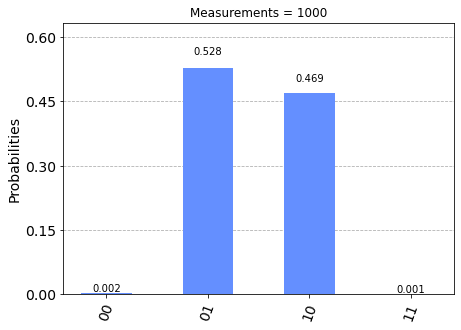

In [18]:
from qiskit.visualization import plot_histogram
plot_histogram(samples[0], title="Measurements = 1000")

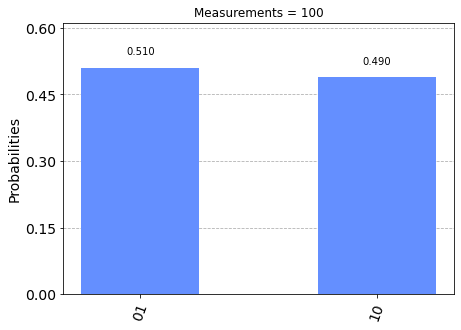

In [19]:
plot_histogram(samples[1], title="Measurements = 100")

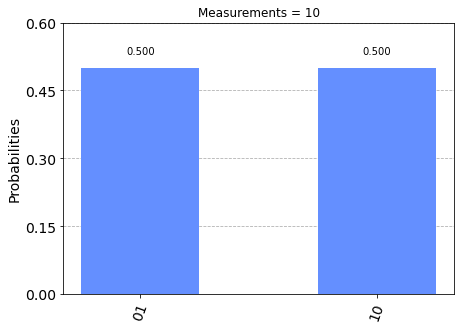

In [20]:
plot_histogram(samples[2], title="Measurements = 10")

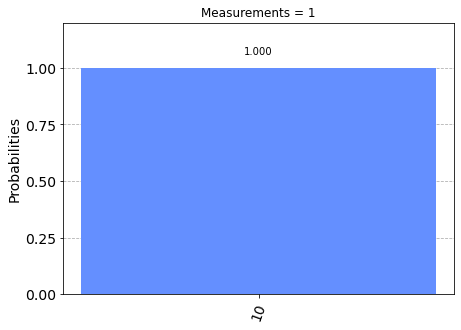

In [21]:
plot_histogram(samples[3], title="Measurements = 1")

# Bonus Question

In [22]:
#Bonus Question
circuit_gates = 2
initial_parameters = parameter_initialization(circuit_gates)
print("Initial parameters = ", initial_parameters)

for i in range(4):
    print("\nMeasurements = ", measurement_count[i])    
    h_probability[str(measurement_count[i])]  = gradient_descent(initial_parameters, objective_function_h, measurement_count[i])

Initial parameters:  [1.40604176 4.01372402]

Measurements:  1000
Minimized cost value = 4.0472443328469585e-07
Minimized parameter = [1.56830213 4.17598439]



Measurements:  100
Minimized cost value = 4.0472443328469585e-07
Minimized parameter = [1.56830213 4.17598439]



Measurements:  10
Minimized cost value = 4.0472443328469585e-07
Minimized parameter = [1.56830213 4.17598439]



Measurements:  1
Minimized cost value = 4.0472443328469585e-07
Minimized parameter = [1.56830213 4.17598439]




# Results for the bonus question 

We can see that the state vector correspond close to 0.7070 x ($|01\rangle$ + $|10\rangle$), and not 0.7070 x ($|01\rangle$ - $|10\rangle$)

In [23]:
state_vector = parametric_quantum_circuit(1, x_probability["1000"][1] , h_probability["1000"][1], 1000)
print(state_vector)

[0.02065573+0.00000000e+00j 0.70725334+1.51627779e-03j
 0.70635403+0.00000000e+00j 0.02068203+4.43401298e-05j]


In [24]:
samples, objective_value = results(x_probability, h_probability)

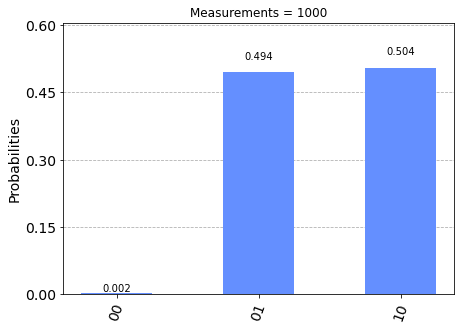

In [25]:
plot_histogram(samples[0], title="Measurements = 1000")

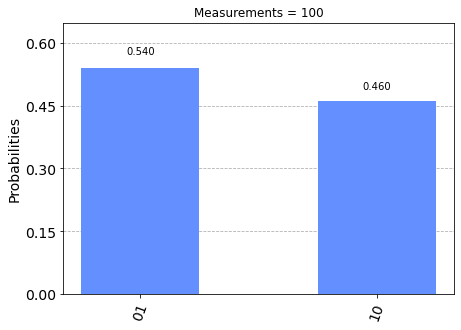

In [26]:
plot_histogram(samples[1], title="Measurements = 100")

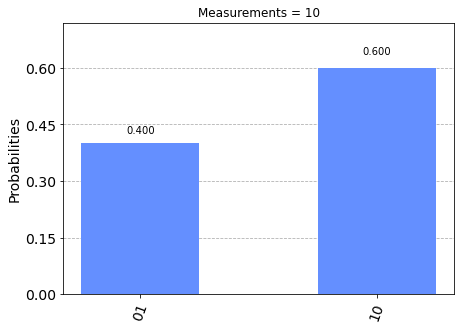

In [27]:
plot_histogram(samples[2], title="Measurements = 10")

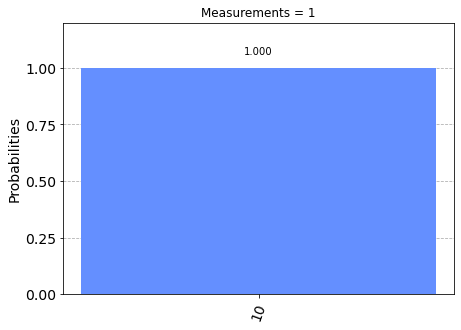

In [28]:
plot_histogram(samples[3], title="Measurements = 1")